## I. Preprocessing

Se cargan las librerías necesarias:

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import warnings
import shap
warnings.filterwarnings("ignore")
from imblearn.over_sampling import BorderlineSMOTE
# from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, silhouette_score, recall_score, precision_score, make_scorer, \
accuracy_score, roc_auc_score, plot_confusion_matrix, f1_score, precision_recall_curve, plot_roc_curve, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV

Procedemos a usar una muestra reducida de 100.000 datos ya que aunque hemos conseguido obtener un dataset más amplio (aproximadamente 2.500.000 datos), nuestros ordenadores no han sido capaces de computar tal cantidad de datos.

In [94]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('df_final.csv')

In [95]:
df.shape

(64513, 17)

In [96]:
df.head()

,fallecidos,n_personas,edad,todos_con_seguridad,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,sexo_M
0,0,1,17.0,False,1,1.0,0.0,1.0,1.0,1.0,1.0,4.0,1.0,18.0,6,1991.0,0
1,0,1,30.0,True,1,1.0,0.0,1.0,1.0,1.0,1.0,5.0,1.0,18.0,1,1981.0,1
2,0,1,20.0,False,1,1.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,18.0,1,1990.0,1
3,0,1,NaN,False,1,1.0,0.0,1.0,1.0,1.0,6.0,3.0,2.0,18.0,1,NaN,0
4,0,1,36.0,False,1,1.0,0.0,1.0,1.0,NaN,1.0,2.0,3.0,18.0,1,1986.0,1


### Variable Recategorization

Recategorizamos ciertas variables. En el caso de C_HOUR, C_WDAY y C_MNTH se ha procedido a dividirlas en partes (por ejemplo las semanas en hábiles-fin de semana). A su vez convertimos todas las demás a string.

In [97]:
df.C_HOUR = pd.cut(df.C_HOUR, bins=[-1, 8, 16, 24], labels=['madrugada', 'dia', 'tarde/noche'])
df.C_WDAY = pd.cut(df.C_WDAY, bins=[-1, 5, 7], labels=['habiles', 'fin de semana'])
df.C_MNTH = pd.cut(df.C_MNTH, bins=[0, 3, 6, 9, 12], labels=['invierno', 'primavera', 'verano', 'otoño'])
df.V_TYPE = df.V_TYPE.astype(str)
df.C_RALN = df.C_RALN.astype(str)
df.C_RSUR = df.C_RSUR.astype(str)
df.C_WTHR = df.C_WTHR.astype(str)
df.C_RCFG = df.C_RCFG.astype(str)
df.C_CONF = df.C_CONF.astype(str)
df.C_VEHS = pd.to_numeric(df.C_VEHS)

In [98]:
df.head()

,fallecidos,n_personas,edad,todos_con_seguridad,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,sexo_M
0,0,1,17.0,False,invierno,habiles,madrugada,1.0,1.0,1.0,1.0,4.0,1.0,18.0,6,1991.0,0
1,0,1,30.0,True,invierno,habiles,madrugada,1.0,1.0,1.0,1.0,5.0,1.0,18.0,1,1981.0,1
2,0,1,20.0,False,invierno,habiles,madrugada,1.0,1.0,1.0,2.0,1.0,1.0,18.0,1,1990.0,1
3,0,1,NaN,False,invierno,habiles,madrugada,1.0,1.0,1.0,6.0,3.0,2.0,18.0,1,NaN,0
4,0,1,36.0,False,invierno,habiles,madrugada,1.0,1.0,nan,1.0,2.0,3.0,18.0,1,1986.0,1


### Dummy Variables

Se procede a realizar la técnica de variables dummy, ya que no era posible realizar el OneHot Encoding.

In [101]:
df = pd.get_dummies(df, drop_first=True)
df

,fallecidos,n_personas,edad,todos_con_seguridad,C_VEHS,C_TRAF,V_YEAR,sexo_M,C_MNTH_primavera,C_MNTH_verano,C_MNTH_otoño,C_WDAY_fin de semana,C_HOUR_dia,C_HOUR_tarde/noche,C_CONF_2.0,C_CONF_21.0,C_CONF_22.0,C_CONF_23.0,C_CONF_24.0,C_CONF_25.0,C_CONF_3.0,C_CONF_31.0,C_CONF_32.0,C_CONF_33.0,C_CONF_34.0,C_CONF_35.0,C_CONF_36.0,C_CONF_4.0,C_CONF_41.0,C_CONF_5.0,C_CONF_6.0,C_CONF_nan,C_RCFG_2.0,C_RCFG_3.0,C_RCFG_4.0,C_RCFG_5.0,C_RCFG_6.0,C_RCFG_7.0,C_RCFG_8.0,C_RCFG_nan,C_WTHR_2.0,C_WTHR_3.0,C_WTHR_4.0,C_WTHR_5.0,C_WTHR_6.0,C_WTHR_7.0,C_WTHR_nan,C_RSUR_2.0,C_RSUR_3.0,C_RSUR_4.0,C_RSUR_5.0,C_RSUR_6.0,C_RSUR_7.0,C_RSUR_9.0,C_RSUR_nan,C_RALN_2.0,C_RALN_3.0,C_RALN_4.0,C_RALN_5.0,C_RALN_6.0,C_RALN_nan,V_TYPE_11,V_TYPE_18,V_TYPE_23,V_TYPE_5,V_TYPE_6,V_TYPE_7,V_TYPE_8,V_TYPE_9
0,0,1,17.0,False,1.0,18.0,1991.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,30.0,True,1.0,18.0,1981.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,20.0,False,1.0,18.0,1990.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,NaN,False,1.0,18.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,36.0,False,1.0,18.0,1986.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64508,0,1,21.0,False,1.0,3.0,1989.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64509,0,2,NaN,True,1.0,18.0,1993.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
64510,0,1,22.0,False,1.0,18.0,1986.0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64511,0,2,45.0,True,1.0,18.0,1988.0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Imputar NAs

Se imputan los NAs del DataFrame mediante la técnica de k-NearestNeighbours, seleccionando los 10 vecinos más cercanos.

In [102]:
imputer = KNNImputer(n_neighbors=10)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [103]:
df

,fallecidos,n_personas,edad,todos_con_seguridad,C_VEHS,C_TRAF,V_YEAR,sexo_M,C_MNTH_primavera,C_MNTH_verano,C_MNTH_otoño,C_WDAY_fin de semana,C_HOUR_dia,C_HOUR_tarde/noche,C_CONF_2.0,C_CONF_21.0,C_CONF_22.0,C_CONF_23.0,C_CONF_24.0,C_CONF_25.0,C_CONF_3.0,C_CONF_31.0,C_CONF_32.0,C_CONF_33.0,C_CONF_34.0,C_CONF_35.0,C_CONF_36.0,C_CONF_4.0,C_CONF_41.0,C_CONF_5.0,C_CONF_6.0,C_CONF_nan,C_RCFG_2.0,C_RCFG_3.0,C_RCFG_4.0,C_RCFG_5.0,C_RCFG_6.0,C_RCFG_7.0,C_RCFG_8.0,C_RCFG_nan,C_WTHR_2.0,C_WTHR_3.0,C_WTHR_4.0,C_WTHR_5.0,C_WTHR_6.0,C_WTHR_7.0,C_WTHR_nan,C_RSUR_2.0,C_RSUR_3.0,C_RSUR_4.0,C_RSUR_5.0,C_RSUR_6.0,C_RSUR_7.0,C_RSUR_9.0,C_RSUR_nan,C_RALN_2.0,C_RALN_3.0,C_RALN_4.0,C_RALN_5.0,C_RALN_6.0,C_RALN_nan,V_TYPE_11,V_TYPE_18,V_TYPE_23,V_TYPE_5,V_TYPE_6,V_TYPE_7,V_TYPE_8,V_TYPE_9
0,0.0,1.0,17.0,0.0,1.0,18.0,1991.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,30.0,1.0,1.0,18.0,1981.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,20.0,0.0,1.0,18.0,1990.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,30.3,0.0,1.0,18.0,1992.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,36.0,0.0,1.0,18.0,1986.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64508,0.0,1.0,21.0,0.0,1.0,3.0,1989.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64509,0.0,2.0,32.9,1.0,1.0,18.0,1993.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
64510,0.0,1.0,22.0,0.0,1.0,18.0,1986.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64511,0.0,2.0,45.0,1.0,1.0,18.0,1988.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
(df.isna().sum()).sum()

0

### Feature Selection

Se procede a seleccionar las distintas variables clave en nuestro modelo. Por un lado la y (variable objetivo del modelo) que va a ser 'fallecidos'. Es decir, la antigua variable 'C_SEV'. En este caso si en un accidente se fallece o no. Por otro lado la X (variables explicativas), las demás del DataFrame que explicarán la objetivo.

In [105]:
X = df.drop(columns='fallecidos')
y = df.fallecidos

In [106]:
y.value_counts()

0.0    64071
1.0      442
Name: fallecidos, dtype: int64

### Distribución de los datos

Se comprueba la distribución de los datos y como están altamente desbalanceados, se representan graficamente.

In [107]:
df.fallecidos.value_counts(normalize=True)*100

0.0    99.314867
1.0     0.685133
Name: fallecidos, dtype: float64

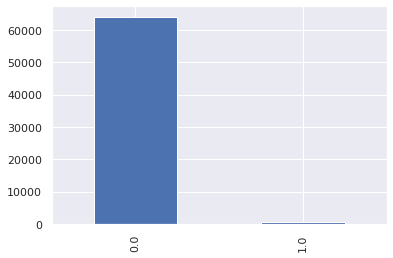

In [108]:
plt.figure(figsize=(6,4))
df.fallecidos.value_counts().plot(kind='bar');

### SMOTE

Procedemos al balanceo de los datos mediante la técnica BorderlineSMOTE.

In [109]:
oversample = BorderlineSMOTE()
X, y = oversample.fit_resample(X, y)

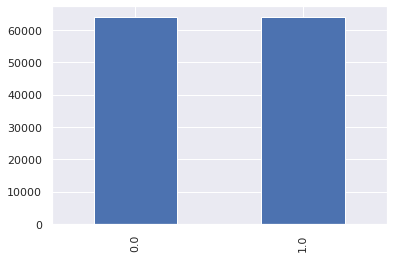

In [110]:
plt.figure(figsize=(6,4))
y.value_counts().plot(kind='bar');

In [111]:
pca = PCA()

In [112]:
Xpca = pca.fit_transform(X)

In [113]:
Xpca[:,0]

array([-22.94056876, -10.36055898, -19.98051734, ...,  24.47525384,
        -7.00915683, -22.0440576 ])

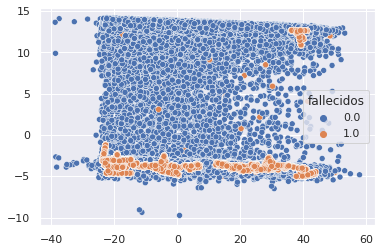

In [114]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=Xpca[:,0], y=Xpca[:,1], hue=y);

In [115]:
pca.explained_variance_ratio_.cumsum()

array([0.81102457, 0.93008195, 0.98967673, 0.9914804 , 0.99280505,
       0.99355016, 0.99410301, 0.99455432, 0.99497115, 0.99538581,
       0.99578749, 0.99612274, 0.99641544, 0.99669876, 0.99697429,
       0.9972269 , 0.9974497 , 0.99766277, 0.99785508, 0.99803847,
       0.99820804, 0.99836815, 0.99851673, 0.99865475, 0.99878542,
       0.99890707, 0.99901859, 0.99912455, 0.99922339, 0.99931809,
       0.9994012 , 0.99947533, 0.99953709, 0.99959088, 0.99963806,
       0.99967701, 0.99971001, 0.99974127, 0.99977089, 0.99979859,
       0.99982468, 0.99984936, 0.99987237, 0.99989094, 0.99990781,
       0.99992199, 0.9999339 , 0.99994427, 0.99995356, 0.99996165,
       0.99996908, 0.99997549, 0.99997984, 0.99998412, 0.99998819,
       0.99999145, 0.99999382, 0.99999566, 0.99999689, 0.999998  ,
       0.99999869, 0.99999933, 0.99999959, 0.99999982, 0.99999998,
       1.        , 1.        , 1.        ])

### División train-test

Dividimos el dataset en train y test

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## II. Modelado

### Definición de las funciones para la estructura y cálculo de los distintos modelos

In [47]:
def model_function(y_test, y_pred):
    
    print('Accuracy: {}\n'.format(accuracy_score(y_test, y_pred)))
    
    score = f1_score(y_test, y_pred)
    print('F1-Score: %.5f' % score)

    print('Classification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    
    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='YlGnBu');
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show();

In [48]:
def models(model):
    
    model.fit(X_train, y_train)   
    print("Model score: %.3f" % model.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
    
    model_function(y_test=y_test, y_pred=y_pred)

### 1) Modelo base (al azar)

Accuracy: 0.49873839190489816

F1-Score: 0.49729
Classification report: 
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50     19349
         1.0       0.50      0.50      0.50     19094

    accuracy                           0.50     38443
   macro avg       0.50      0.50      0.50     38443
weighted avg       0.50      0.50      0.50     38443


Confusion matrix:


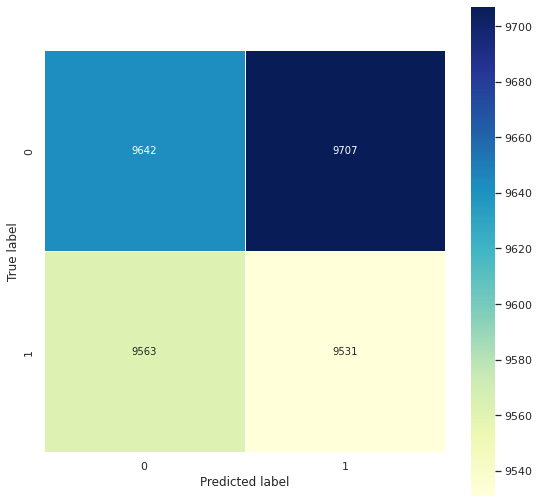

In [37]:
random_list = []
for i in range(0, len(y_test)):
    n = random.randint(0,1)
    random_list.append(n)
    
model_function(y_test, y_pred=random_list)

### 2) Modelo Regresión Logística

In [39]:
lr = LogisticRegression()

Model score: 0.860
Accuracy: 0.8595843196420675

F1-Score: 0.86203
Classification report: 
              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86     19349
         1.0       0.84      0.88      0.86     19094

    accuracy                           0.86     38443
   macro avg       0.86      0.86      0.86     38443
weighted avg       0.86      0.86      0.86     38443


Confusion matrix:


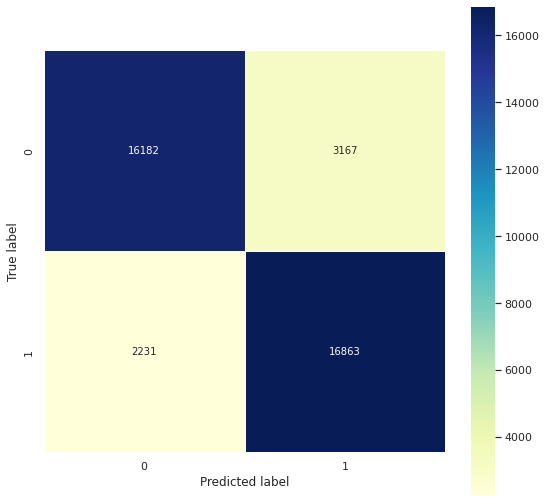

In [40]:
models(lr)

### 3) Modelo Decision Tree

In [41]:
dt = DecisionTreeClassifier()

Model score: 0.991
Accuracy: 0.9911817496033088

F1-Score: 0.99114
Classification report: 
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     19349
         1.0       0.99      0.99      0.99     19094

    accuracy                           0.99     38443
   macro avg       0.99      0.99      0.99     38443
weighted avg       0.99      0.99      0.99     38443


Confusion matrix:


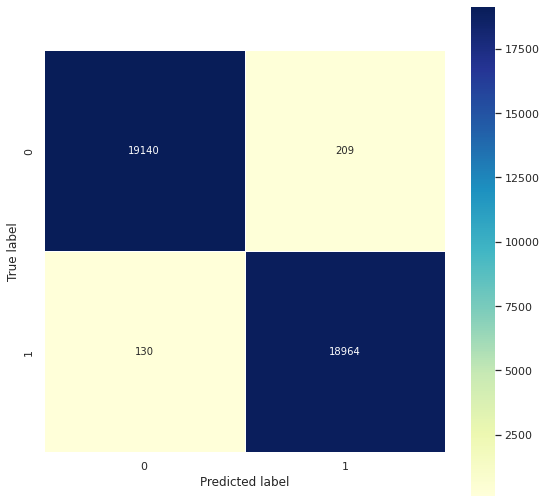

In [42]:
models(dt)

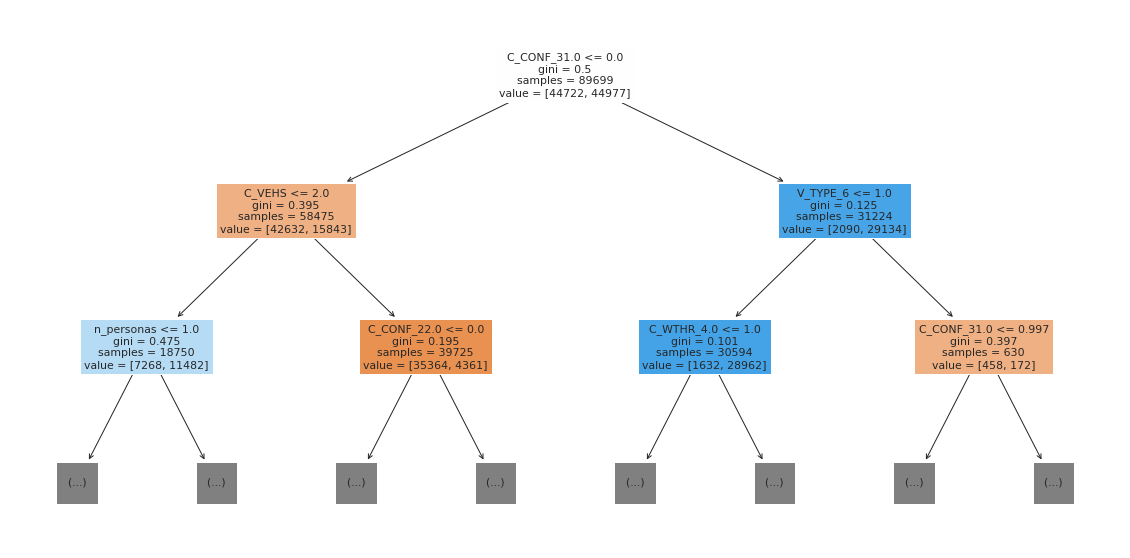

In [43]:
plt.figure(figsize=(20, 10))
plot_tree(decision_tree=dt, max_depth=2, feature_names=X.columns, filled=True);

### 4) Modelo XGBoost

In [118]:
xgb =  XGBClassifier()

[09:23:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model score: 0.997
Accuracy: 0.9965143199021929

F1-Score: 0.99648
Classification report: 
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     19349
         1.0       1.00      0.99      1.00     19094

    accuracy                           1.00     38443
   macro avg       1.00      1.00      1.00     38443
weighted avg       1.00      1.00      1.00     38443


Confusion matrix:


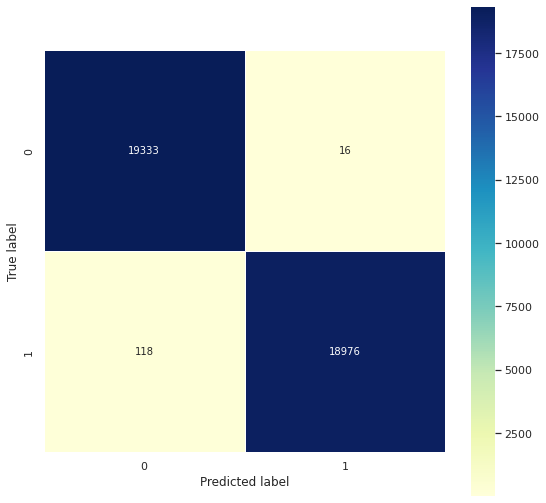

In [119]:
models(xgb)

### 5) Modelo LightGBM

In [35]:
lgbm = LGBMClassifier(random_state=123)

Model score: 0.997
Accuracy: 0.9966183700543662

F1-Score: 0.99659
Classification report: 
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     19349
         1.0       1.00      0.99      1.00     19094

    accuracy                           1.00     38443
   macro avg       1.00      1.00      1.00     38443
weighted avg       1.00      1.00      1.00     38443


Confusion matrix:


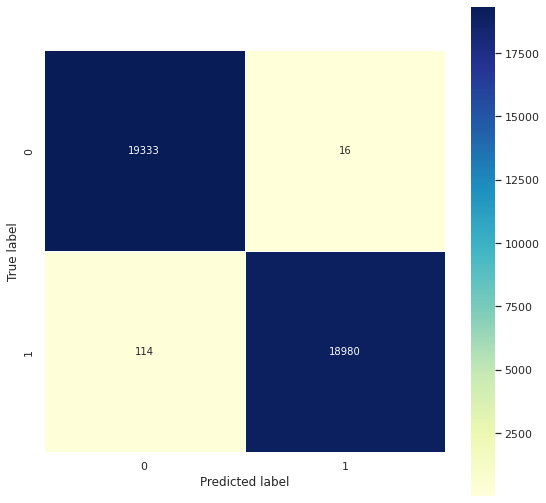

In [36]:
models(lgbm)

### 6) Modelo Random Forest

In [71]:
rf = RandomForestClassifier(random_state=123)

Model score: 0.997
Accuracy: 0.9967484327445829

F1-Score: 0.99672
Classification report: 
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     19349
         1.0       1.00      0.99      1.00     19094

    accuracy                           1.00     38443
   macro avg       1.00      1.00      1.00     38443
weighted avg       1.00      1.00      1.00     38443


Confusion matrix:


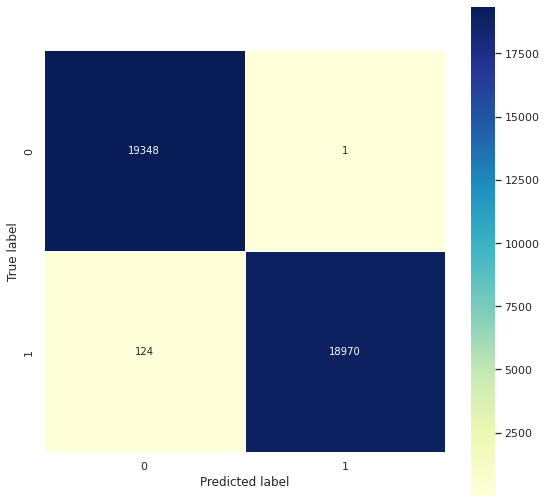

In [133]:
models(rf)

Nuestro modelo elegido que mejor predice es el Random Forest. Procedemos a buscar los hiperparámetros más óptimos del modelo por si se pudiera mejorar el modelo.

#### Optimización de hiperparámetros

In [73]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [74]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, 40, 80], 'max_features': ['auto', 3, 5, 7]}

In [75]:
cv = GridSearchCV(estimator=rf, param_grid=param_grid, verbose=2)

In [76]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END .....criterion=gini, max_depth=5, max_features=auto; total time=   3.1s
[CV] END .....criterion=gini, max_depth=5, max_features=auto; total time=   3.1s
[CV] END .....criterion=gini, max_depth=5, max_features=auto; total time=   3.1s
[CV] END .....criterion=gini, max_depth=5, max_features=auto; total time=   3.1s
[CV] END .....criterion=gini, max_depth=5, max_features=auto; total time=   3.1s
[CV] END ........criterion=gini, max_depth=5, max_features=3; total time=   1.8s
[CV] END ........criterion=gini, max_depth=5, max_features=3; total time=   1.8s
[CV] END ........criterion=gini, max_depth=5, max_features=3; total time=   1.8s
[CV] END ........criterion=gini, max_depth=5, max_features=3; total time=   1.8s
[CV] END ........criterion=gini, max_depth=5, max_features=3; total time=   1.8s
[CV] END ........criterion=gini, max_depth=5, max_features=5; total time=   2.3s
[CV] END ........criterion=gini, max_depth=5, m

GridSearchCV(estimator=RandomForestClassifier(random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 40, 80],
                         'max_features': ['auto', 3, 5, 7]},
             verbose=2)

In [77]:
cv.best_params_

{'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto'}

In [122]:
rf = RandomForestClassifier(criterion='entropy', max_depth=80, max_features=7)

Model score: 0.997
Accuracy: 0.9967224202065396

F1-Score: 0.99669
Classification report: 
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     19349
         1.0       1.00      0.99      1.00     19094

    accuracy                           1.00     38443
   macro avg       1.00      1.00      1.00     38443
weighted avg       1.00      1.00      1.00     38443


Confusion matrix:


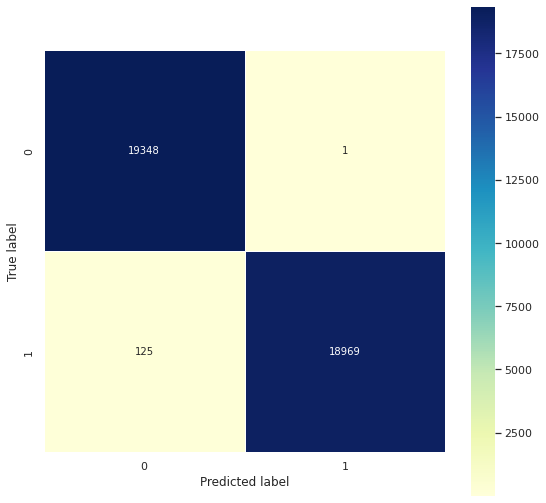

In [132]:
models(rf)

## III. Interpretabilidad

### Feature Importance

Realizamos este gráfico para mostrar las variables en orden de importancia.

En primer lugar tenemos la variable 'C_CONF' que explica el tipo o configuración de la colisión en el accidente, y supone la caracteristica más relevante a la hora de segregar dentro del modelo. En segundo lugar tenemos 'n_personas', que mide el número de personas involucradas en el accidente, seguido de 'C_TRAF' y 'C_RCFG'.

<AxesSubplot:>

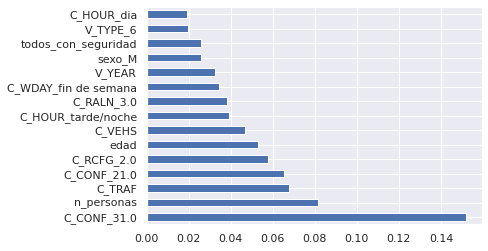

In [80]:
(pd.Series(rf.feature_importances_, index=X.columns)
   .nlargest(15)
   .plot(kind='barh'))  

### SHAP Values

Para la interpretabilidad local utilizaremos el método SHAP. El método Shap es un metodo para explicar las predicciones individuales, se basa en los valores de Shapley.

In [81]:
shap.initjs()

In [83]:
explainer = shap.TreeExplainer(rf)

In [84]:
shap_values=explainer.shap_values(X_train.iloc[0:100,:])

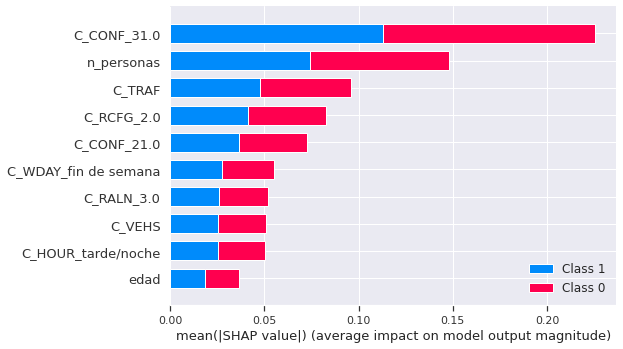

In [126]:
shap.summary_plot(shap_values, features=X_train.iloc[0:100,:], max_display=10)

Este gráfico nos muestra donde el eje de las 'x' corresponde al valor del SHAP, y el eje de las 'y' corresponde a las variables ordenadas por importancia.

En este caso, tomamos las 10 más importantes, y en función de los colores rojo (high) y azul (low) sabemos el efecto que de dicha variable sobre el valor SHAP.
El valor del SHAP esta correlacionado con el score de nuestro modelo predictivo de la siguiente forma: valores de SHAP bajos contribuyen hacia un score de cero y valores de SHAP alto hacía un score más cercano uno.

Si un mismo color esta presente a ambos lados (partiendo del valor SHAP = 0), esto supone que esos valores (sean altos o bajos) contribuyen de la misma forma tanto a que el score sea cero como uno, lo que nos informa de la neutralidad de la variable en este sentido. Este ejemplo se ve claramente en el caso de la variable C_HOUR.

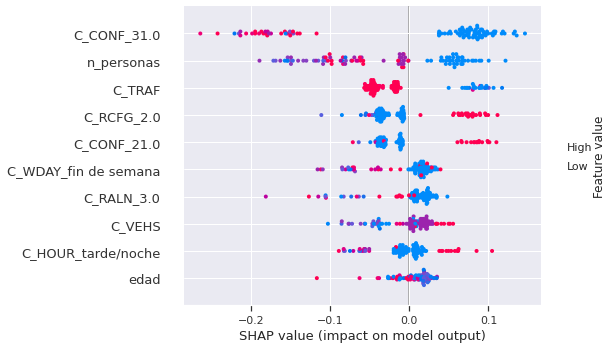

In [87]:
shap.summary_plot(shap_values[0], features=X_train.iloc[0:100,:], max_display=10)

In [128]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train.iloc[0,:])

En el gráfico anterior se detalla esta influencia anteriormente descrita de las variables sobre los valores SHAP y el score del modelo a nivel de fila, tomando únicamente en este caso el primer registro.

In [130]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:100,:], features=X_train.iloc[:100, :])

En este gráfico obtenemos una representación equivalente a la anterior pero a nivel agregado de los cien primeros registros, que ha sido el total utilizado para calcular los valores SHAP.